# Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from tqdm import tqdm

# Data preprocessing

In [21]:
metrics = ['name', 'ch_area', 'ch_volume', 'ch_area_normed', 'ch_volume_normed', 'frac_dim', 'C1', 'C2', 'C3', 'C4', 'C5',
           'alpha_d', 'alpha_j', 'num_samples_d', 'num_samples_j']

features = ['ch_area', 'ch_volume', 'ch_area_normed', 'ch_volume_normed', 'frac_dim',
           'C1', 'C2', 'C3', 'C4', 'C5']

sides = ['CT', 'T']

In [22]:
filename = '../Outputs/cleaned-5-player-features-3d-rounds.parquet'

save_files = True

## Loading the dataset

In [23]:
orig_df = pd.read_parquet(filename)

In [24]:
metrics_dict = {}

In [25]:
for metric in metrics:
  metrics_dict[metric] = pd.concat([orig_df[f'p{i}_{metric}'] for i in range(1, 6)], ignore_index=True)

metrics_df = pd.DataFrame(metrics_dict)

In [26]:
id_metrics = ['matchID', 'mapName', 'side', 'roundNum']
id_df = orig_df[id_metrics]

In [27]:
id_df_copy = id_df.copy()

for i in range(4):
  id_df = pd.concat([id_df, id_df_copy], ignore_index=True)

In [28]:
metrics_df = pd.concat([id_df, metrics_df], axis=1) # now every row is a single player in a round

## Removing outliers (alive for less than 30 seconds)

In [29]:
# number of player rounds in the dataset before removing outliers
len(metrics_df)

103340

In [30]:
metrics_df['time_alive'] = (metrics_df['num_samples_d'] + metrics_df['num_samples_j']) / 2

In [31]:
df = metrics_df[metrics_df['time_alive'] >= 30]

In [32]:
# number of players after removing outliers
len(df)

99612

In [33]:
# Check how many outliers are removed
print(len(metrics_df) - len(df))

3728


## Dataset visualization

array([[<Axes: title={'center': 'ch_area'}>,
        <Axes: title={'center': 'ch_volume'}>,
        <Axes: title={'center': 'ch_area_normed'}>],
       [<Axes: title={'center': 'ch_volume_normed'}>,
        <Axes: title={'center': 'frac_dim'}>,
        <Axes: title={'center': 'C1'}>],
       [<Axes: title={'center': 'C2'}>, <Axes: title={'center': 'C3'}>,
        <Axes: title={'center': 'C4'}>],
       [<Axes: title={'center': 'C5'}>, <Axes: >, <Axes: >]], dtype=object)

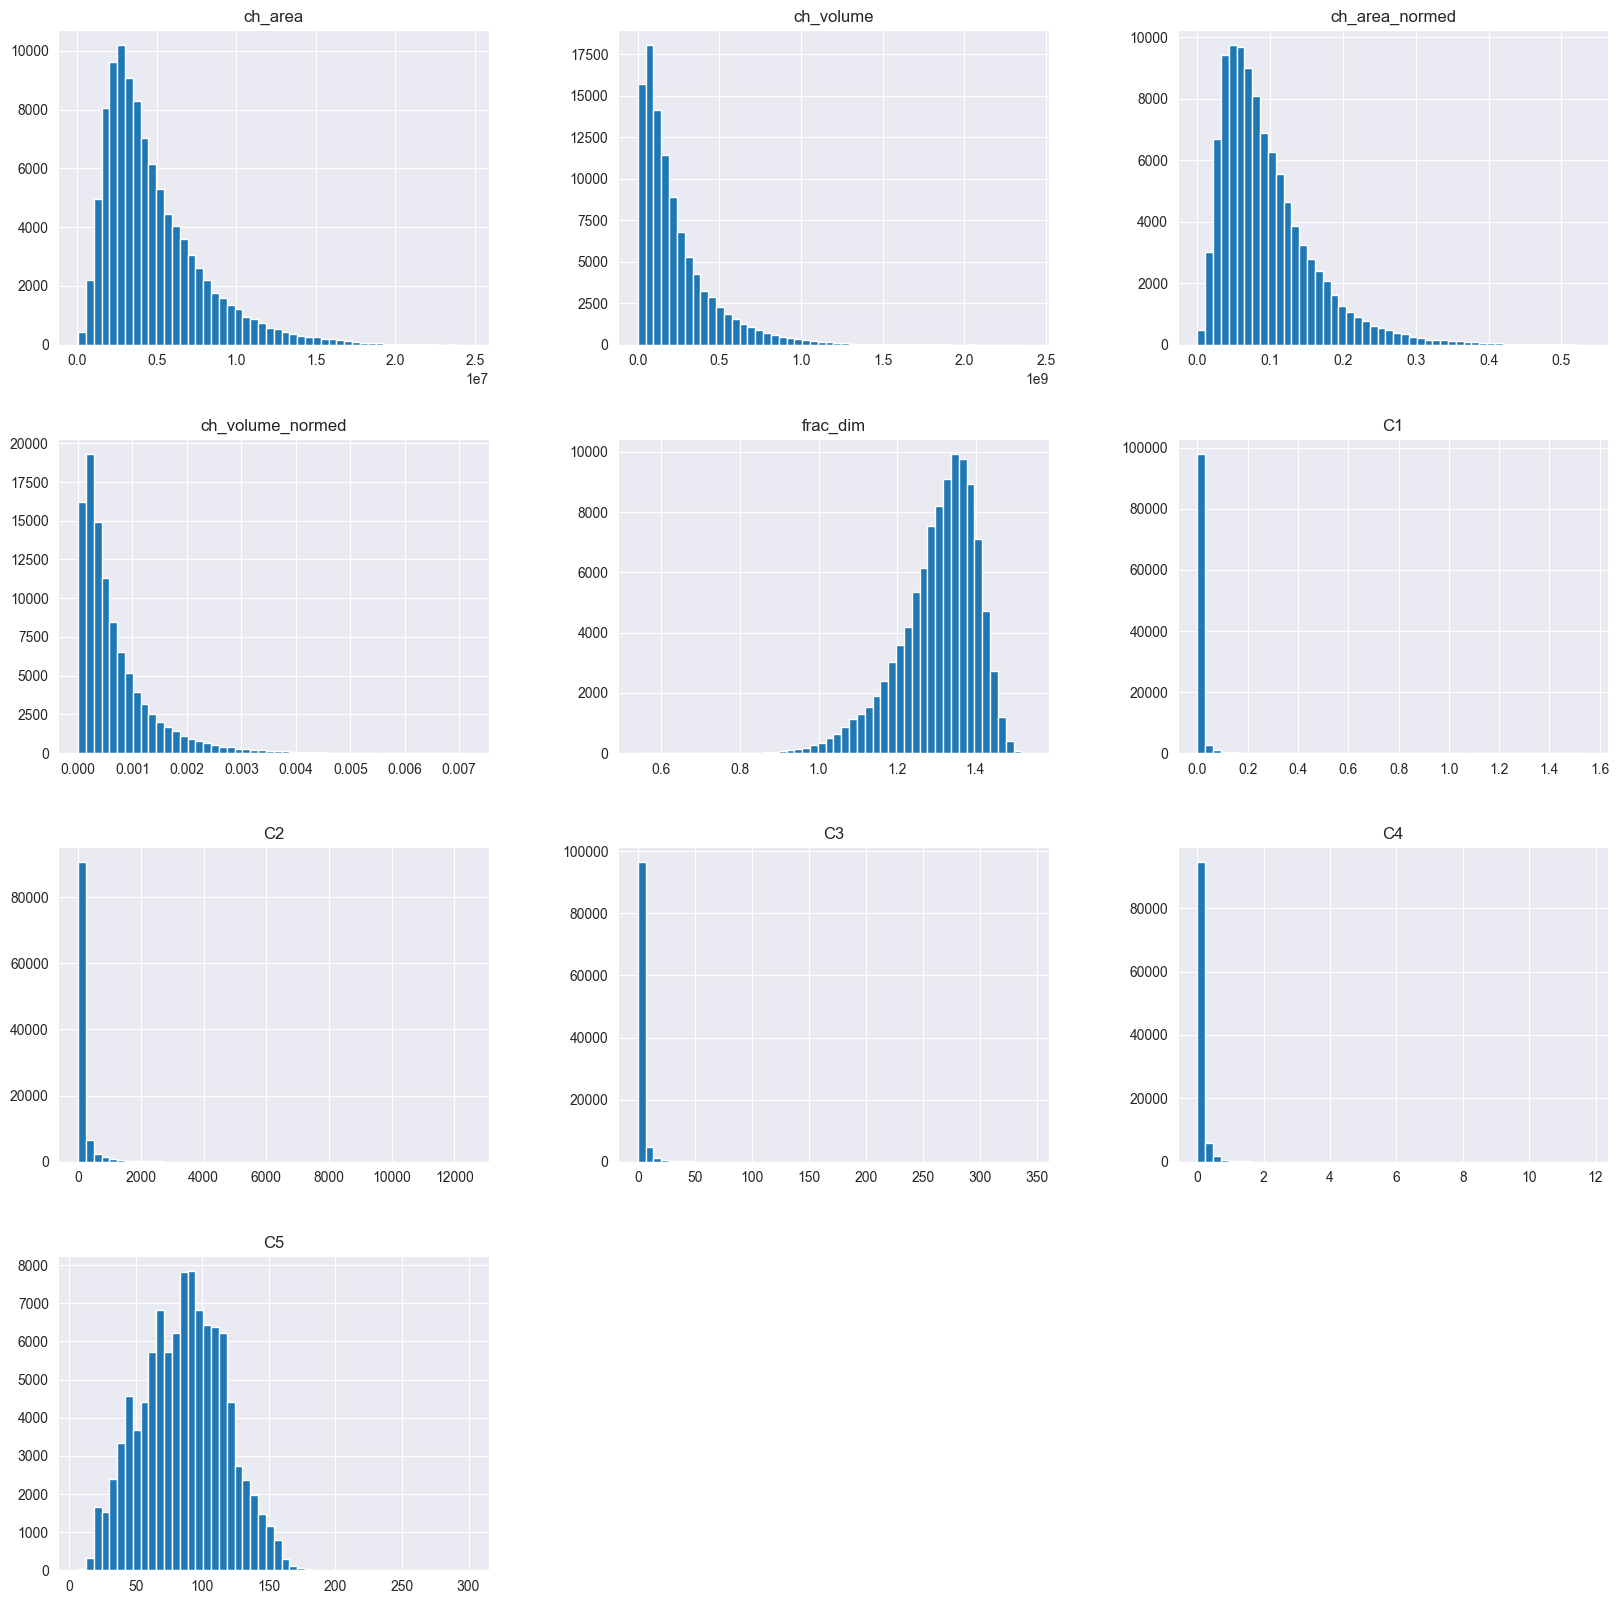

In [34]:
metrics_df[features].hist(figsize=(20, 20), bins=50)

## Getting scaled feature vectors

In [35]:
scaled_data = {}

for side, group in df.groupby('side'):
  scaler = MinMaxScaler()
  feature_vectors = group[features]
  scaled_data[side] = scaler.fit_transform(feature_vectors)

In [36]:
for side in scaled_data:
  print(side, scaled_data[side].shape)

CT (51299, 10)
T (48313, 10)


# AIC scores

In [37]:
aic_scores_sides = {'T': [], 'CT': []}

k_values = list(range(2, 21))

In [38]:
for side in scaled_data:

  print(side)
  data_side = scaled_data[side]

  for k in tqdm(k_values):

    model = GaussianMixture(n_components = k, random_state = 42, init_params='k-means++', max_iter=1000)
    model.fit(data_side)

    aic_scores_sides[side].append(model.aic(data_side))

CT


100%|██████████| 19/19 [03:51<00:00, 12.18s/it]


T


100%|██████████| 19/19 [03:21<00:00, 10.58s/it]


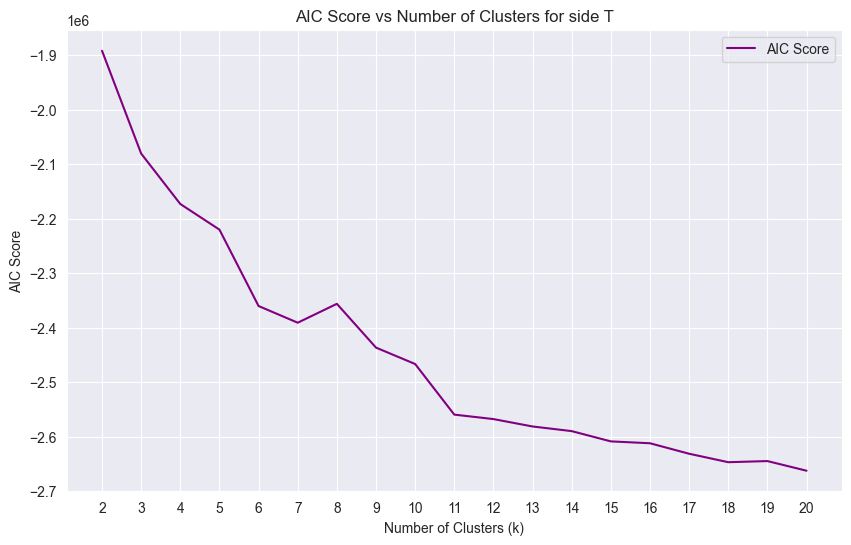

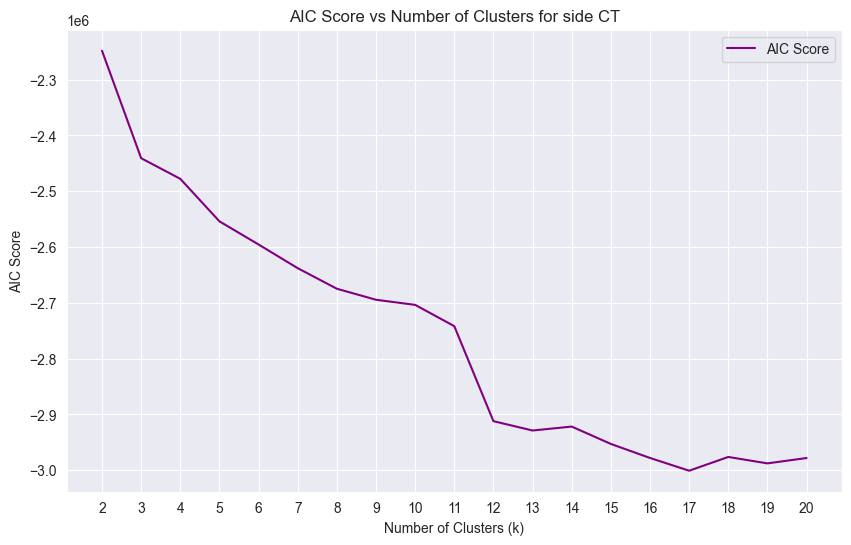

In [39]:
for side in aic_scores_sides:
  scores = aic_scores_sides[side]

  plt.figure(figsize=(10, 6))
  plt.plot(k_values, list(scores), 'purple', label=f'AIC Score')
  plt.title(f'AIC Score vs Number of Clusters for side {side}')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('AIC Score')
  plt.legend()
  plt.xticks(k_values)
  plt.grid(True)
  plt.show()

# GMMs with scaled data (for sides T and CT)

In [40]:
num_clusters_list = [4, 8]

models = {}

In [41]:
for side in scaled_data:
  print(f'side: {side}')

  for num_clusters in tqdm(num_clusters_list):

    # learning the model
    model = GaussianMixture(n_components = num_clusters, random_state = 42, init_params='k-means++')
    model.fit(scaled_data[side])

    # saving the model in a dictionary
    models[(side, num_clusters)] = model


side: CT


100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


side: T


100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


# Visualization

In [42]:
# creating the PCA objects

sides_pca = {}

for side in scaled_data:
  pca = PCA(n_components=3)
  pca.fit(scaled_data[side])

  sides_pca[side] = pca

In [43]:
# create a dictionary of label colors
label_colors = {}

for i in range(len(mpl.colormaps['tab20'].colors)):
  label_colors[i] = np.asarray(mpl.colormaps['tab20'].colors[i])

In [44]:
def down_sample_points(data_array, label_array, color_array, sample_size=100):
    # Find unique labels
    unique_labels = np.unique(label_array)

    # Initialize lists to store sampled data, labels, and colors
    sampled_data = []
    sampled_labels = []
    sampled_colors = []

    # Iterate over each unique label
    for label in unique_labels:
        # Find indices of data points corresponding to the current label
        indices = np.where(label_array == label)[0]

        # Sample indices randomly from the current label
        sampled_indices = np.random.choice(indices, size=min(sample_size, len(indices)), replace=False)

        # Append sampled data, labels, and colors to respective lists
        sampled_data.extend(data_array[sampled_indices])
        sampled_labels.extend(label_array[sampled_indices])
        # print(color_array[0:5])
        # print(len(color_array))
        # print(len(sampled_indices))
        # print(color_array[sampled_indices])
        for i in range(len(sampled_indices)):
          sampled_colors.append(color_array[sampled_indices[i]])

    # Convert lists to arrays
    sampled_data = np.array(sampled_data)
    sampled_labels = np.array(sampled_labels)
    sampled_colors = np.array(sampled_colors)

    return sampled_data, sampled_labels, sampled_colors

In [45]:
# Used to visualize Gaussians based on covariance of the entire dataset
def plot_distributions(ax, mean, cov, pca, color='0.5', alpha=0.25, plot_means = True):
    # Create a grid of points
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Create a 3x100x50 array for points
    points = np.stack((x, y, z), axis=0)

    if cov.shape[0] > 3:

        # Transform the mean the same way as the data
        mean = pca.transform(mean.reshape(1, -1))[0]

        # Transform the covariance matrix
        cov = pca.components_ @ cov @ pca.components_.T

    # Decompose the covariance matrix to get the axes lengths and rotations
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Reverse the order since above returns in ascending order
    eigenvalues = np.flip(eigenvalues)
    eigenvectors = np.flip(eigenvectors)

    # The lengths of the axes are proportional to the square roots of the eigenvalues (aka the singular values)
    radii = np.sqrt(eigenvalues)

    # Rotate the points
    points = np.einsum('ij,jkl->ikl', eigenvectors, points) * radii[:, np.newaxis, np.newaxis]
    points = points + mean[:, np.newaxis, np.newaxis]

    # Plot the surface
    ax.plot_surface(points[0], points[1], points[2], color=color, alpha=alpha, rstride=4, cstride=4, linewidth=0)

    if plot_means:
        ax.scatter(mean[0], mean[1], mean[2], marker='x', s=50, color=color)

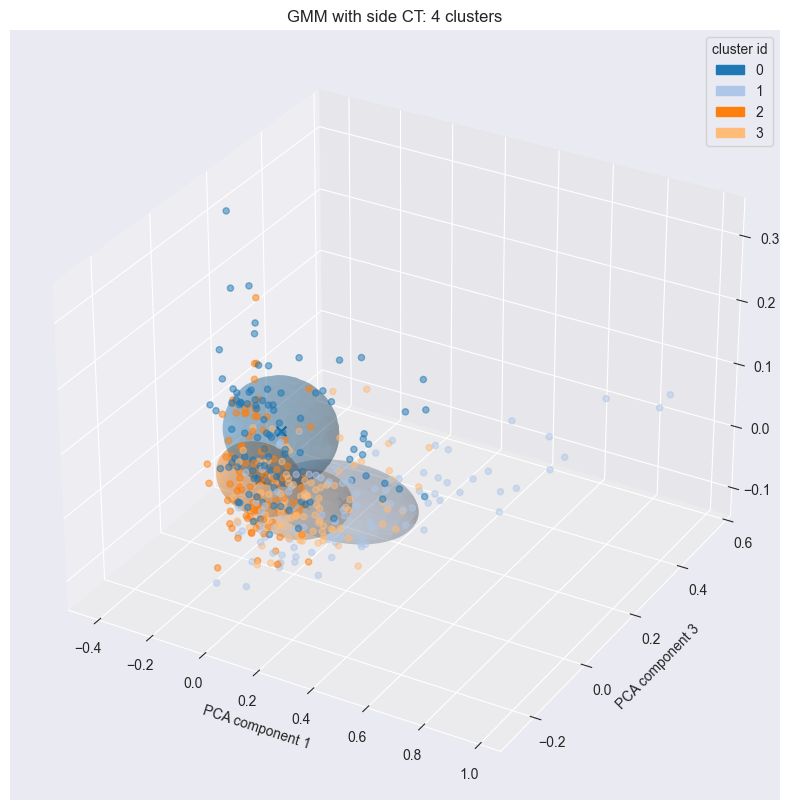

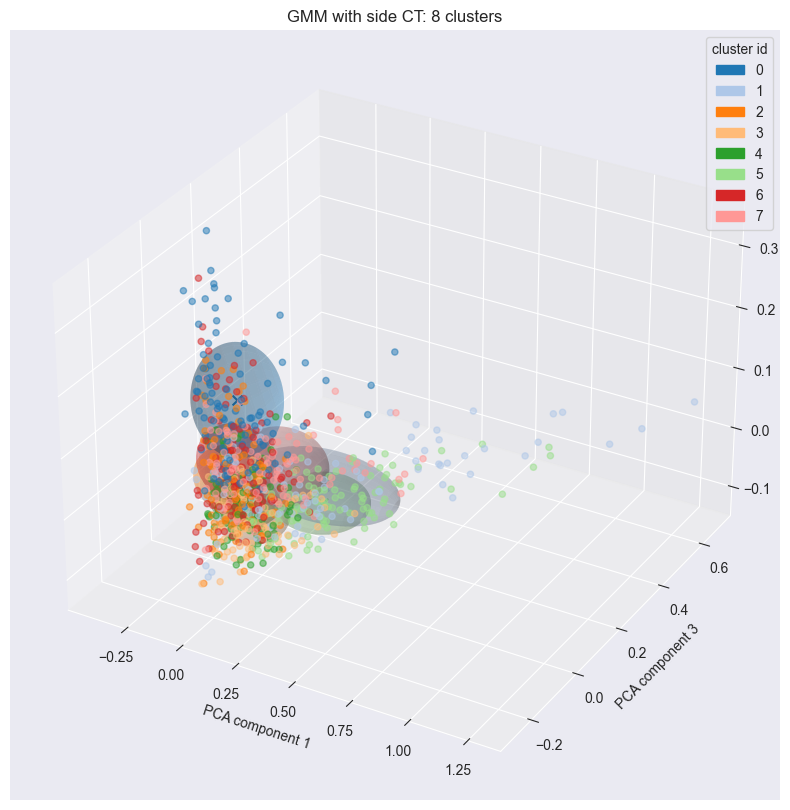

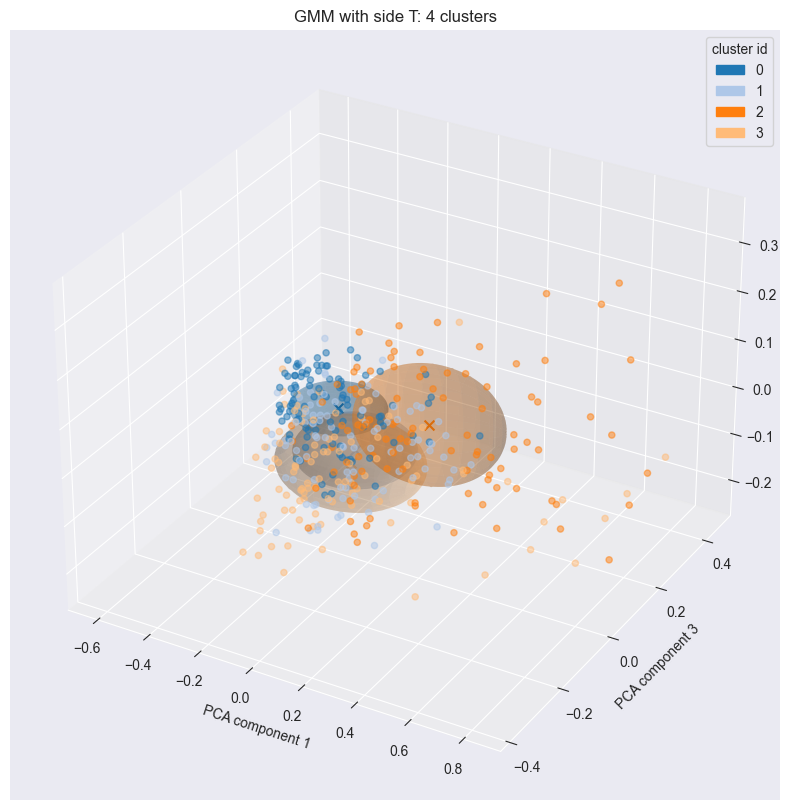

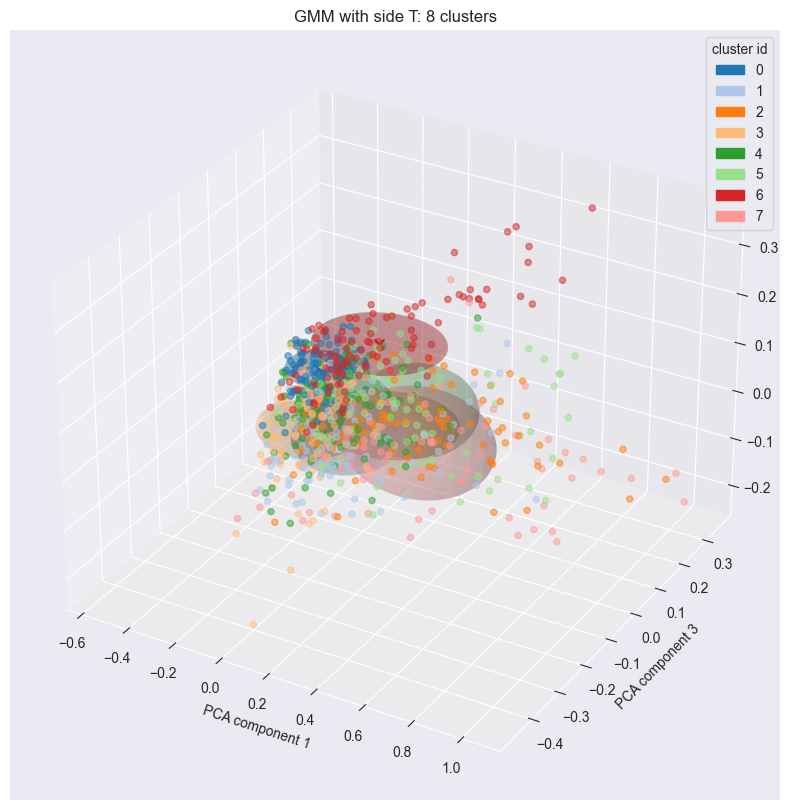

In [46]:
down_sample_num = 100

for side in sides:
  pca = sides_pca[side]

  for num_clusters in num_clusters_list:
    model = models[(side, num_clusters)]
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # data and labels
    data_array = pca.fit_transform(scaled_data[side])
    label_array = model.predict(scaled_data[side])

    # make the label_colors dictionary shorter (length is the number of clusters)
    colors_to_use = {}
    for i in range(num_clusters):
      colors_to_use[i] = label_colors[i]

    # map labels to colors
    colors = []

    for label in label_array:
      colors.append(label_colors[label])

    # downsample points for clarity
    if down_sample_num > 0:
        data_array, label_array, colors = down_sample_points(data_array, label_array, colors, down_sample_num)

    # plot the points
    ax.scatter(data_array[:, 0], data_array[:, 1], data_array[:, 2], color=colors, alpha=0.5)

    # plot the distributions
    for i in range(num_clusters):
      plot_distributions(ax, model.means_[i], model.covariances_[i], pca, list(label_colors.values())[i])

    # legend and axis labels
    legend_handles = []
    for cluster in range(num_clusters):
      legend_handles.append(mpatches.Patch(color=label_colors[cluster], label=cluster))
      ax.legend(handles=legend_handles, title="cluster id")

    ax.set_xlabel("PCA component 1")
    ax.set_ylabel("PCA component 2")
    ax.set_ylabel("PCA component 3")

    # view and title
    fig.set_size_inches(18, 10, forward=True)
    # ax.view_init(elev=0, azim=90, roll=0)
    plt.title(f"GMM with side {side}: {num_clusters} clusters")
    plt.show()

# Looking at the cluster means (to give each one a playstyle label)

## Means dataframe

In [47]:
means_dfs = []
for side in sides:
  for num_clusters in num_clusters_list:
    means = models[(side, num_clusters)].means_

    means_df = pd.DataFrame(means)
    means_df.columns = features
    means_df['side'] = side
    means_df['num_clusters'] = num_clusters
    means_dfs.append(means_df)

In [48]:
means_df = pd.concat(means_dfs) # each row is the mean features in a cluster

In [49]:
means_df

,ch_area,ch_volume,ch_area_normed,ch_volume_normed,frac_dim,C1,C2,C3,C4,C5,side,num_clusters
0,0.163261,0.078357,0.136733,0.069241,0.676634,0.024619,0.051847,0.027218,0.021994,0.298888,CT,4
1,0.259392,0.179403,0.206143,0.146565,0.802317,0.006975,0.012926,0.004665,0.005259,0.269659,CT,4
2,0.104068,0.033787,0.102600,0.038197,0.670132,0.001267,0.006387,0.007950,0.007695,0.185089,CT,4
3,0.193931,0.094975,0.164485,0.087560,0.752733,0.000378,0.003346,0.005213,0.004641,0.216004,CT,4
0,0.135111,0.054480,0.117893,0.052148,0.619087,0.059520,0.082430,0.036491,0.036686,0.302754,CT,8
1,0.309496,0.215634,0.237720,0.167379,0.802377,0.024229,0.020626,0.004766,0.008635,0.293544,CT,8
2,0.106602,0.035064,0.107035,0.040581,0.684601,0.008232,0.006301,0.007515,0.019537,0.217967,CT,8
3,0.186160,0.090183,0.113318,0.043689,0.759465,0.001922,0.003488,0.004255,0.005597,0.214659,CT,8
4,0.119909,0.048270,0.121642,0.055638,0.694660,0.000946,0.001751,0.003469,0.003911,0.156584,CT,8
5,0.261448,0.180309,0.261095,0.198175,0.801485,0.002268,0.003297,0.003879,0.003480,0.245759,CT,8


## How many players are in each cluster?

In [50]:
for side in sides:
  for num_clusters in num_clusters_list:
    cluster_ids = models[(side, num_clusters)].predict(scaled_data[side])
    print(f'Player counts in {num_clusters} clusters on {side} side:')
    print(pd.Series(cluster_ids).value_counts())
    print()

Player counts in 4 clusters on CT side:
2    18207
3    15367
1     9688
0     8037
Name: count, dtype: int64

Player counts in 8 clusters on CT side:
4    12334
3     8414
6     8038
7     6118
2     5642
5     5630
1     2843
0     2280
Name: count, dtype: int64

Player counts in 4 clusters on T side:
1    16568
0    14773
2    11504
3     5468
Name: count, dtype: int64

Player counts in 8 clusters on T side:
4    9996
2    9328
1    7129
0    7046
5    5497
6    4396
3    2772
7    2149
Name: count, dtype: int64



## T side means

In [51]:
means_df[(means_df['side'] == 'T') & (means_df['num_clusters'] == 4)]

,ch_area,ch_volume,ch_area_normed,ch_volume_normed,frac_dim,C1,C2,C3,C4,C5,side,num_clusters
0,0.161040,0.067975,0.171354,0.078927,0.614206,0.004060,0.003715,0.004344,0.001817,0.174191,T,4
1,0.214432,0.105154,0.218824,0.115097,0.691458,0.000077,0.022386,0.016068,0.012961,0.326140,T,4
2,0.359231,0.226242,0.307116,0.191146,0.768470,0.009851,0.008906,0.006765,0.007639,0.346401,T,4
3,0.219367,0.118362,0.208523,0.113705,0.663738,0.035918,0.083958,0.029164,0.028596,0.372253,T,4


## CT side means

In [52]:
means_df[(means_df['side'] == 'CT') & (means_df['num_clusters'] == 4)]

,ch_area,ch_volume,ch_area_normed,ch_volume_normed,frac_dim,C1,C2,C3,C4,C5,side,num_clusters
0,0.163261,0.078357,0.136733,0.069241,0.676634,0.024619,0.051847,0.027218,0.021994,0.298888,CT,4
1,0.259392,0.179403,0.206143,0.146565,0.802317,0.006975,0.012926,0.004665,0.005259,0.269659,CT,4
2,0.104068,0.033787,0.102600,0.038197,0.670132,0.001267,0.006387,0.007950,0.007695,0.185089,CT,4
3,0.193931,0.094975,0.164485,0.087560,0.752733,0.000378,0.003346,0.005213,0.004641,0.216004,CT,4


# Map distributions

## Add cluster id's to original dataframe

In [53]:
for side in sides:
  print(side)

  for num_clusters in num_clusters_list:
    print(num_clusters)
    cluster_ids = models[(side, num_clusters)].predict(scaled_data[side])

    df.loc[(df.side == side), f'{num_clusters}_clusters'] = cluster_ids

CT
4
8
T
4
8


C:\Users\reiad\AppData\Local\Temp\ipykernel_12788\3154050681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df.side == side), f'{num_clusters}_clusters'] = cluster_ids
C:\Users\reiad\AppData\Local\Temp\ipykernel_12788\3154050681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df.side == side), f'{num_clusters}_clusters'] = cluster_ids


In [54]:
# make the cluster id numbers integers instead of floats
for num_clusters in num_clusters_list:
  df[f'{num_clusters}_clusters'].astype(int, copy=False)

## Look at how much of each map there is in each cluster

In [55]:
# how much of each map is there in the dataset?
df['mapName'].value_counts() / df['mapName'].value_counts().sum()

mapName
de_inferno     0.218016
de_mirage      0.183713
de_nuke        0.150645
de_vertigo     0.114655
de_overpass    0.114534
de_ancient     0.109645
de_dust2       0.108792
Name: count, dtype: float64

In [56]:
# mean features in each map (unscaled)

for map, group in df.groupby(['side', 'mapName']):
  print(map)
  print(group[features].mean())
  print()

('CT', 'de_ancient')
ch_area             3.987491e+06
ch_volume           1.328631e+08
ch_area_normed      1.142401e-01
ch_volume_normed    6.442921e-04
frac_dim            1.310832e+00
C1                  8.259482e-03
C2                  1.605265e+02
C3                  3.268864e+00
C4                  9.193214e-02
C5                  8.680354e+01
dtype: float64

('CT', 'de_dust2')
ch_area             3.665599e+06
ch_volume           1.793998e+08
ch_area_normed      8.729611e-02
ch_volume_normed    6.593210e-04
frac_dim            1.317551e+00
C1                  1.220978e-02
C2                  1.805851e+02
C3                  3.280684e+00
C4                  9.246542e-02
C5                  8.877495e+01
dtype: float64

('CT', 'de_inferno')
ch_area             4.610012e+06
ch_volume           1.456705e+08
ch_area_normed      7.691228e-02
ch_volume_normed    3.139150e-04
frac_dim            1.303127e+00
C1                  1.089275e-02
C2                  2.187433e+02
C3              

In [57]:
for num_clusters in num_clusters_list:
  for name, group in df.groupby(['side', f'{num_clusters}_clusters']):
    print(f'cluster {name[1]} on {name[0]} side when there are {num_clusters} clusters')
    print(group['mapName'].value_counts() / group['mapName'].value_counts().sum())
    print()

cluster 0.0 on CT side when there are 4 clusters
mapName
de_inferno     0.293393
de_mirage      0.158144
de_nuke        0.148687
de_dust2       0.109369
de_overpass    0.107752
de_vertigo     0.095558
de_ancient     0.087097
Name: count, dtype: float64

cluster 1.0 on CT side when there are 4 clusters
mapName
de_overpass    0.282411
de_inferno     0.203964
de_nuke        0.173514
de_mirage      0.115813
de_dust2       0.087944
de_ancient     0.081131
de_vertigo     0.055223
Name: count, dtype: float64

cluster 2.0 on CT side when there are 4 clusters
mapName
de_mirage      0.276762
de_vertigo     0.197452
de_ancient     0.146262
de_dust2       0.133026
de_inferno     0.131268
de_nuke        0.098204
de_overpass    0.017026
Name: count, dtype: float64

cluster 3.0 on CT side when there are 4 clusters
mapName
de_inferno     0.304549
de_nuke        0.198998
de_overpass    0.148825
de_mirage      0.125919
de_ancient     0.089217
de_dust2       0.083946
de_vertigo     0.048546
Name: count, 